In [6]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import common

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

from sklearn import preprocessing
from sklearn import metrics

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [7]:
df = common.load_df("../data/insead", "*.csv")
print(common.load_df.cache_info())
df["weekday"] = df.index.weekday
df["weekend"] = df.weekday.apply(lambda x: int(x in (5,6)))
df["hour"] = df.index.hour

CacheInfo(hits=2, misses=1, maxsize=None, currsize=1)


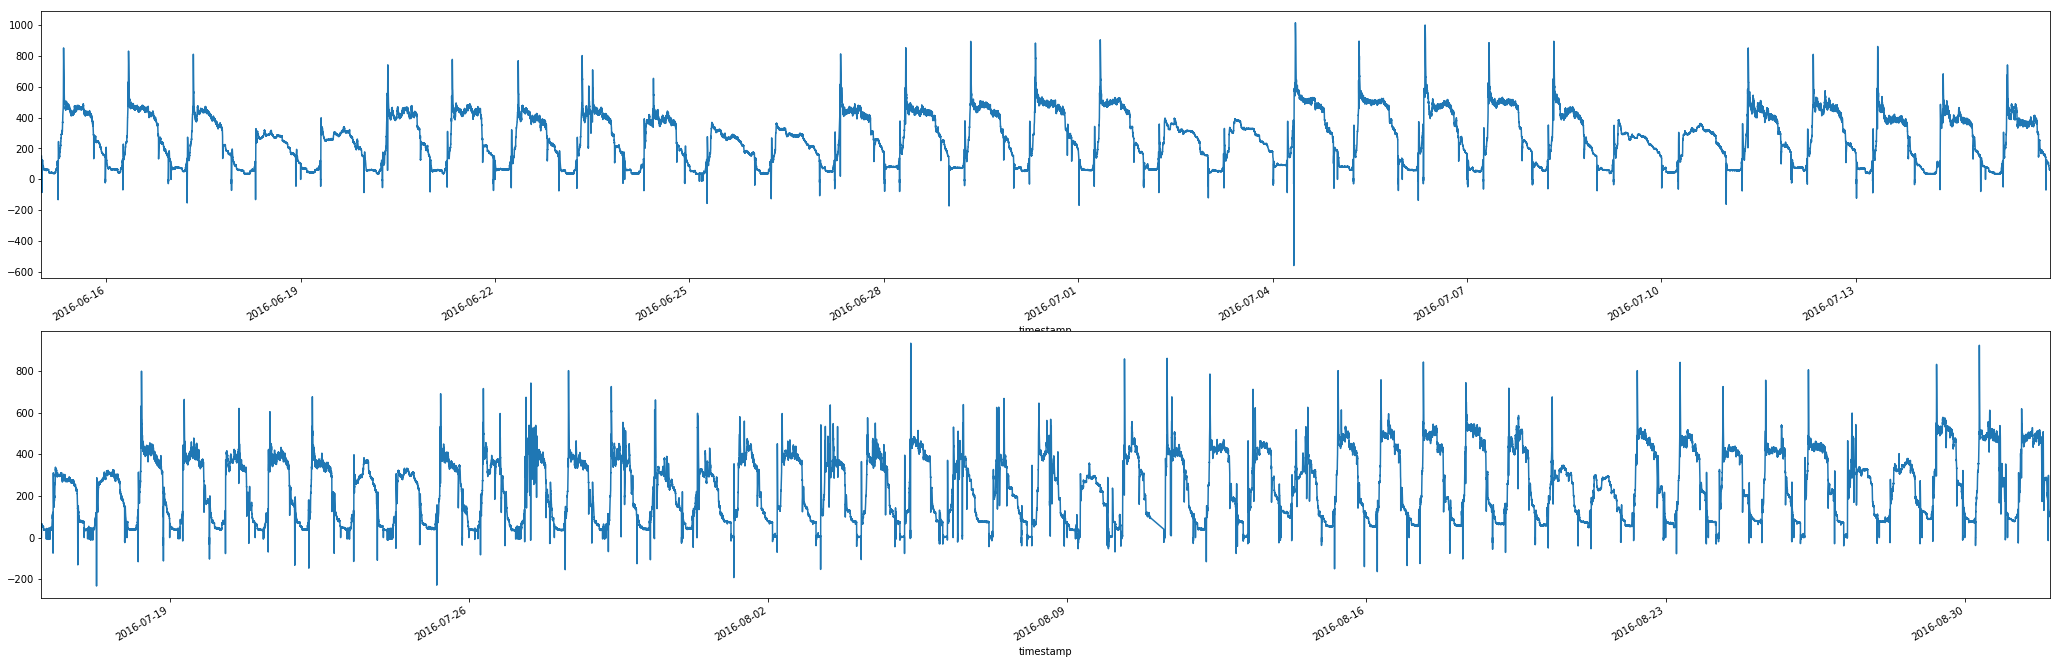

In [5]:
fig, ax = plt.subplots(2,1,figsize=(36,12))
train.loadsys.plot(ax=ax[0])
test.loadsys.plot(ax=ax[1])

In [8]:
# Plant is probably shut down.. 
def remove_negatives(df, columns=[]):
    columns = columns or df.columns
    for col in columns:
        df.loc[df[col] < 0, col] = 0
    return df


# replace missing values with rolling mean.. following by interpolation.. 
def replace_missing(df, columns=[]):
    columns = columns or df.columns
    rolling_avg = df[columns].rolling(10, min_periods=1).mean()
    df[columns] = df[columns].fillna(rolling_avg).fillna(method="ffill")
    return df


# normalize the data
def get_normalized_df(dataframe, scale=(0,1), columns=[]):
    # columns and index
    columns = columns or dataframe.columns
    index = dataframe.index.values
    
    # fit the scaler
    scaler = preprocessing.MinMaxScaler(scale)
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=columns, index=index)
    
    # attach the scaler..
    dataframe.scaler = scaler
    return dataframe


# process.. 
df = remove_negatives(df)
df = replace_missing(df)
df = get_normalized_df(df, scale=(0.1, 1))

In [9]:
# Remove values from the dataframe at beginning so that the
# length is a multiple of batch size. Needed for training.
def equalize_length(arr, batch, where="start"):
    cnt = arr.shape[0]
    return arr[cnt % batch:] if where == "start" else arr[: cnt - (cnt % batch)]


# prepare feature vectors. the hypothesis is that
# y(t) can be determined using x1(k), x2(k), x3(k).... for all k = {t-1, t-2, t-3, ... t-N}, where 0 <= N <= t-1
def prepare_features(dataframe, features, target, N=1):
    x, y = [], []
    features_data = dataframe[features].values
    target_data = dataframe[target].values
    
    for i in range(dataframe.shape[0]-N-1):
        x.append(features_data[i:i+N])
        y.append(target_data[i+N])
    
    x = np.array(x)
    y = np.array(y)
    return x, y


# Make features vector 1D & adjust to Keras requirement
shape_x = lambda a: a.reshape((a.shape[0], 1, a.shape[1] * a.shape[2]))
shape_y = lambda a: a.reshape((a.shape[0], 1, 1))

## Experiment 1
```
X = DB, Rh, Hour, Weekday
y = Loadsys

Train: Mid Jun-Jul
Test: Mid Jul-Aug
```

In [10]:
# manually select training and validaiton data.
batch_size = 200
train_df = df["2016-06-15":"2016-07-14"]
validation_df = df["2016-07-15":"2016-08-14"]

# The recipe.
features = ["drybulb", "rh", "hour", "weekend"]
target = ["loadsys"]
lookback = 5

# Prepare features and target vectors
train_x, train_y = prepare_features(train_df, features, target, N=lookback)
validation_x, validation_y = prepare_features(validation_df, features, target, N=lookback)
print(train_x.shape, train_y.shape)

# Equalize length
train_x = equalize_length(train_x, batch_size)
train_y = equalize_length(train_y, batch_size)
validation_x = equalize_length(validation_x, batch_size)
validation_y = equalize_length(validation_y, batch_size)

# Reshape to Keras requirements
train_x = shape_x(train_x)
train_y = shape_y(train_y)
validation_x = shape_x(validation_x)
validation_y = shape_y(validation_y)
print(train_x.shape, train_y.shape)

(43109, 5, 4) (43109, 1)
(43000, 1, 20) (43000, 1, 1)


In [13]:
model = Sequential([
    LSTM(15, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    LSTM(10, stateful=True, return_sequences=True),
    LSTM(5, stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

In [14]:
for epoch in range(150):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras13")])
    model.reset_states()
    if epoch % 50 == 0:
        print("At epoch ", epoch)

At epoch  0
At epoch  50
At epoch  100
